In [1]:
import torch
import torch.nn as nn 
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from sklearn.model_selection import train_test_split
import numpy as np
from torchsummary import summary
from PIL import Image
import torch.nn.functional as F
from torchvision.datasets import FakeData # Test
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import math

Size of data_coins 10000 : Size of labels_coins 10000
Size of data_others 10000 : Size of labels_others 10000


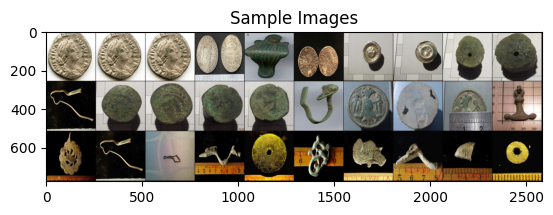

In [2]:
# Load data from external source
import os
from torchvision.io import read_image
import matplotlib.pyplot as plt
import torchvision
import numpy as np

# Docs:
# https://pytorch.org/tutorials/beginner/basics/data_tutorial.html?highlight=dataloader

# 256x256 images
path_to_coins = "/run/media/magnusjsc/T7/Classification-and-3D-reconstruction-of-archaeological-artifacts_DATA/resized_images_coin_256x256/"
path_to_others = "/run/media/magnusjsc/T7/Classification-and-3D-reconstruction-of-archaeological-artifacts_DATA/resized_images_others_256x256/"

def load_data_from_directory_with_limit(directory_path, label, limit=10000):
    data = []
    labels = []
    count = 0

    for filename in os.listdir(directory_path):
        if filename.endswith(".jpg"): 
            image_path = os.path.join(directory_path, filename)
            image = read_image(image_path)

            # Check if the image is RGB
            if image.shape[0] == 3:
                data.append(image)
                labels.append(label)
                count += 1

            if count >= limit:
                break

    return data, labels # Tuple

# Load data call
data_coins, labels_coins = load_data_from_directory_with_limit(path_to_coins, label=1, limit=10000)
data_others, labels_others = load_data_from_directory_with_limit(path_to_others, label=0, limit=10000)

print(f'Size of data_coins {len(data_coins)} : Size of labels_coins {len(labels_coins)}')
print(f'Size of data_others {len(data_others)} : Size of labels_others {len(labels_others)}')

def imshow_grid(images, num_images=30):
    grid = torchvision.utils.make_grid(images[:num_images], nrow=10)
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.title('Sample Images')
    plt.axis('on')
    plt.show()

num_images_to_display_per_category = 15
data_to_display = data_coins[:num_images_to_display_per_category] + data_others[:num_images_to_display_per_category]
imshow_grid(data_to_display, num_images=num_images_to_display_per_category * 2)

In [3]:
import os
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split
from torchvision import transforms
from torchvision.io import read_image
import torch
import torchvision
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import numpy as np

class customDataset(Dataset):
    def __init__(self, tensors, transform=None):
        # Check the sizes of data and labels match
        assert all(tensors[0].size(0)==t.size(0) for t in tensors), "Size mismatch between tensors"

        # Assign input
        self.tensors = tensors
        self.transform = transform

    # What to do when we want an item from the dataset
    def __getitem__(self, index):
        # Return the transformed version of x if there are transforms
        if self.transform:
            x = self.transform(self.tensors[0][index])
        else: 
            x = self.tensors[0][index]

        # And return the label too
        y = self.tensors[1][index].view(1) # Convert y to a single-element tensor

        return x,y # Return the data as a tuple (data,label)

    def __len__(self):
        return self.tensors[0].size(0)


# Create a list of  transforms
imgTrans = transforms.Compose(
    [
        transforms.ToPILImage(), # PIL = library for images - Works for several transformations. To PIL image type
        transforms.RandomVerticalFlip(p=.5),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor() # Transform the image to PyTorch tensor and normalizes the data [0;1] - Last 
    ]
)

# To Torch tensors
coin_dataT = torch.stack(data_coins)
coin_labelsT = torch.tensor(labels_coins)
other_dataT = torch.stack(data_others)
other_labelsT = torch.tensor(labels_others)

# For the Coin dataset
coin_data_transformed_defined = customDataset(tensors=(coin_dataT, coin_labelsT), transform=imgTrans)
# For the Other dataset
other_data_transformed_defined = customDataset(tensors=(other_dataT, other_labelsT), transform=imgTrans)
# Combine these two above datasets
combined_dataset_transformed_defined = ConcatDataset([coin_data_transformed_defined, other_data_transformed_defined])

# Split the data for training, validation, and testing
training = 0.7
validation = 0.15
testing = 0.15

total_size = len(combined_dataset_transformed_defined)
train_size = int(training * total_size)
val_size = int(validation * total_size)
test_size = total_size - train_size - val_size

# Randomly split the full dataset into training, validation and testing sets
train_set, val_set, test_set = random_split(combined_dataset_transformed_defined, [train_size, val_size, test_size])

# Hyperparameter - Batch size 
BATCH_SIZE = 2
# Create data loaders for each set
coin_loader = DataLoader(coin_data_transformed_defined, batch_size=BATCH_SIZE, shuffle=False) # For test -> below cell
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True) # Shuffle the training set
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

print(f'Total number of elements in train_loader: {len(train_loader) * BATCH_SIZE} : Each batch size {len(train_loader)}')
print(f'Total number of elements in val_loader: {len(val_loader) * BATCH_SIZE} : Each batch size {len(val_loader)}')
print(f'Total number of elements in test_loader: {len(test_loader) * BATCH_SIZE} : Each batch size {len(test_loader)}')

Total number of elements in train_loader: 14000 : Each batch size 7000
Total number of elements in val_loader: 3000 : Each batch size 1500
Total number of elements in test_loader: 3000 : Each batch size 1500


IndexError: index 2 is out of bounds for dimension 0 with size 2

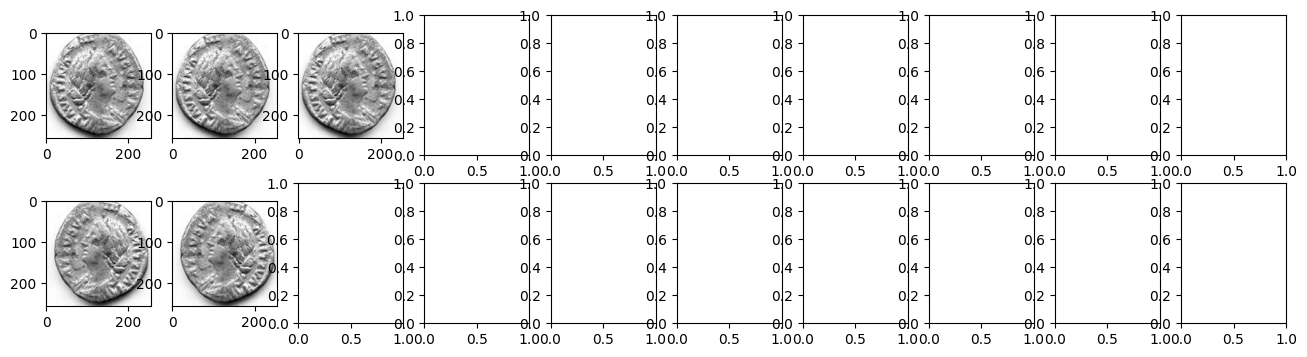

In [4]:
# Get a mini-batch from the train_loader and show differences before and after transformation
# Get the first 10 images from the train_loader
X, y = next(iter(coin_loader))

fig, axs = plt.subplots(2, 10, figsize=(16, 4))

# Loop over the first 10 images
for i in range(10):
    # Original images
    axs[0, i].imshow(coin_dataT[i, 0, :, :].detach().numpy(), cmap='gray')
    # Transformed images
    axs[1, i].imshow(X[i, 0, :, :].detach().numpy(), cmap='gray')

# Set labels
axs[0, 0].set_ylabel('Original')
axs[1, 0].set_ylabel('Transformed (Torch)')

plt.show()

In [75]:
# https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html
# Paper: https://arxiv.org/abs/1706.03762 
# Tutorial: https://www.akshaymakes.com/blogs/vision-transformer
# https://towardsdatascience.com/transformers-explained-visually-part-3-multi-head-attention-deep-dive-1c1ff1024853

# Take a batch of images and patch each individual image 
def divide_images_into_patches(images, patch_size):
    patches_list = [] # List with list of image patches 
    
    for image in images:
        height, width = image.shape[1], image.shape[2]  # Return height and width
        patch_height, patch_width = patch_size
        patches = []

        # Sliding window approach
        for y in range(0, height, patch_height):
            for x in range(0, width, patch_width):
                patch = image[:, y:y + patch_height, x:x + patch_width]
                flattened_patch = patch.flatten()
                patches.append(flattened_patch) # 16x16 patches for each image

        patches_list.append(patches) # All images in a batch containing the list of patches for each image

    return patches_list


# Hyperparameters
mlp_size=4096 # FFN 
image_size=(256,256)
num_classes=[0,1]
num_heads=16
activation='gelu'
num_channels=3, # RGB
embeding_dimension=256 # 16x16
projection_dim=512 # Each pixel has 2 values 16x16=256 -> 256*2=512 pixel values (x,y)
patch_size=(16,16)

def createTheCoinClassifier(printtoggle=False):
    # ViT class
    class VisionTransformerCoinImageClassifier(nn.Module):
        def __init__(self, printtoggle=False):
            super(VisionTransformerCoinImageClassifier, self).__init__()
            self.print = printtoggle

    
            # Calculate the number of patches
            image_num_patches = (image_size[0] // patch_size[0]) * (image_size[1] // patch_size[1])
            num_pixel_values_patch_RGB = image_num_patches * 3 
    
            # Output = patches. Out: Each pixel has one value in R^d space. 
            self.linear_projection = nn.Linear(in_features=num_pixel_values_patch_RGB, out_features=num_pixel_values_patch_RGB, bias=True)
    
            # Multihead attention
            self.attention = nn.MultiheadAttention(embed_dim=embeding_dimension, num_heads=num_heads)
    
            # FFN
            self.feedforward = nn.Sequential(
                nn.Linear(embeding_dimension, mlp_size),
                nn.GELU(),
                nn.Linear(embeding_dimension, mlp_size),
                nn.GELU()
            )
    
            # Normalization for attention and FFN
            self.norm = nn.LayerNorm(embeding_dimension, eps=1e-6)
    
    
    
        def forward(self, x, y): # y = class label
            x = x.float()
    
            # Divide image into patches
            image_list = divide_images_into_patches(x, (16,16))
            print(f'PATCHES LIST {image_list[0][0][0]}') 
            print(f'Y VALUE {y}')
            
            # Apply linear projection to each patch in each image
            x += [[self.linear_projection(patch) for patch in image] for image in image_list]
                    
            # Prepend class label to the first flattened patch
            # y + patches_list
    
            # Positional encoding
            position = torch.arange(0, x.size(1)).unsqueeze(0).float() # One long tensor from 0 to num_patches - 1. Unsqeeze = colomn vector
            div_term = torch.exp(torch.arange(0, x.size(2), 2).float()) * -(math.log(10000.0)) # 2 -> Step. use exp(_ * -math...) on every entry
                # exp = e^n. 10000 is arbritary and ensures the model to generalized inputs.
                # The log is the inverse operation of the exp. So the 10000 is for scaling.
            pos_enc = torch.sin(position * div_term)
            cos_pos_enc = torch.cos(position * div_term)
    
            # Combine Sine and Cosine Components:
            pos_enc = torch.cat([torch.sin(position * div_term), cos_pos_enc], dim=-1)
            x = x + pos_enc # Apply the positional encoding to x to shift/relate it in dimension. Matrix addition

            # Encoder steps
            x = self.norm(x)
            x = self.attention(x)
            x = self.norm(x)
            x = feedforward(x) ## TODO: Add concatenate after attention and after MLP
            
            x = self.norm(x)
            x = self.attention(x)     
            x = self.norm(x)
            x = feedforward(x)
    
            x = self.norm(x)
            x = self.attention(x)
            x = self.norm(x)
            x = feedforward(x)

            # Classification steps - MLP Head - One layer -> Guess class 

            # TODO: Figure out how Transformers/ViT learn
    
            return x

    # Model
    model = VisionTransformerCoinImageClassifier(printtoggle)
    # Loss function
    lossFun = nn.BCEWithLogitsLoss() # BCE=−1/n​∑i=1​(y_i​log(yHat_​i​)+(1−y_i​)log(1−yHat_i​))
    # Optimizer 
    optimizer = Adam(model.parameters(), lr=.001)

    return model, lossFun, optimizer

In [76]:
# Train the model on a minibatch for testing
from torch.optim import Adam

# Training loop
def train(model, loss_func, optimizer, num_epochs=5):
    for epoch in range(num_epochs):
        # Iterate over your dataset here
        for input_data, target in train_loader:
            optimizer.zero_grad()
            output = model(input_data, target)
            loss = loss_func(output, target)
            loss.backward()
            optimizer.step()


# Training
model, loss_func, optimizer = createTheCoinClassifier(printtoggle=True)
train(model, loss_func, optimizer, num_epochs=5)

PATCHES LIST 0.8235294222831726
Y VALUE tensor([[1],
        [1]])


TypeError: unsupported operand type(s) for +=: 'Tensor' and 'list'